In [1]:
import pandas as pd
import numpy as np

In [2]:
# Model to generate power curve from nominale power and rotor dimension

#Fonction générant la power curve
def PowerCurveGenerator(P, d, TI = 0.10, cut_in = 3.5, cut_out = 25, Cp = 0.44, normalized = False):
    """
    This function generate wind turbine power curve from nominal power and rotor dimension and turbulence intensity used to smooth the power curve (10% by default).
    List of parameters : P (rated power) expressed in kW, d (rotor diameter) expressed in m.
    Cut-in wind speed and cut-out wind speed can be adjusted, by default values are 3.5 m/s and 25 m/s. 
    Cp value is set at 0.44 corresponding to the mean value of a set of wind turbine model. 
    """
    #Convertion from kW to W
    P = P*1e3
    
    #Physical parameters
    rho = 1.225 #kg/m3, air density, could be calculated based on temperature and altitude
    S = np.pi * (d/2)**2 #m², rotor area
    
    #Calculation parameters
    a = 5 #m/s, Truncature width of the Gaussian filter for turbulence intensity
    speed_step = 0.1 #Step for wind power curve
    
    #Power calculation (P proportional to wind_speed^3)
    df_bpc = pd.DataFrame(index = np.arange(0, 40 + speed_step, speed_step), columns = ['wind_speed'])
    df_bpc['wind_speed'] = df_bpc.index
    df_bpc['P'] = 1/2 * rho * S * Cp * df_bpc.wind_speed**3 
    #Saturation of the power output to the nominal value
    df_bpc['P'][ df_bpc['P'] >  P ] = P  
    #Gaussian filter over w*(1-TI):w*(1+TI), TI being the turbulence intensity
    df_bpc['P_with_TI'] = np.nan
    df_bpc.iloc[ ::int(1/speed_step), df_bpc.columns.get_loc('P_with_TI')] = [ df_bpc['P'].rolling(window = int(a*TI*w/speed_step), win_type='gaussian', center = True).mean(std = int(TI*w/speed_step)).loc[w] for w in np.arange(0,41)]
    df_bpc['P_with_TI'].interpolate(method='cubic', inplace = True)
    df_bpc['P_with_TI'][df_bpc['P_with_TI'] < 0] = 0
    df_bpc['P_with_TI'][df_bpc['wind_speed'] < (1-2*TI)*cut_in] = 0

    #Cut-in wind speed and cutout wind speed
    df_bpc['P'][ df_bpc['wind_speed'] < cut_in] = 0
    df_bpc['P'][ df_bpc['wind_speed'] > cut_out] = 0
    df_bpc['P_with_TI'][ df_bpc['wind_speed'] > cut_out] = 0
    
    
    del df_bpc['wind_speed']
    df_bpc['P'] = df_bpc['P']/1e3
    df_bpc['P_with_TI'] = df_bpc['P_with_TI']/1e3
    df_bpc = df_bpc.replace(np.nan, 0)
    df_bpc.index.name = 'wind speed'
    
    if normalized:
        df_bpc = df_bpc/(P*1e-3)
             
    return df_bpc

In [3]:
df_bpc = PowerCurveGenerator(P = 3000, d = 90, TI = 0.10, cut_in = 3.5, cut_out = 25, Cp = 0.44, normalized = False)
df_bpc.iloc[:300:10]

P    P_with_TI
wind speed                          
0.0            0.000000     0.000000
1.0            0.000000     0.000000
2.0            0.000000     0.000000
3.0            0.000000    47.558504
4.0          109.727035   108.628198
5.0          214.310615   220.172556
6.0          370.328743   371.190814
7.0          588.068328   604.149209
8.0          877.816279   885.312418
9.0         1249.859507  1284.033500
10.0        1714.484921  1733.998362
11.0        2281.979430  2273.679644
12.0        2962.629943  2659.466318
13.0        3000.000000  2890.128755
14.0        3000.000000  2969.193470
15.0        3000.000000  2995.661693
16.0        3000.000000  2999.955200
17.0        3000.000000  3000.000000
18.0        3000.000000  3000.000000
19.0        3000.000000  3000.000000
20.0        3000.000000  3000.000000
21.0        3000.000000  3000.000000
22.0        3000.000000  3000.000000
23.0        3000.000000  3000.000000
24.0        3000.000000  3000.000000
25.0        3000.000000  3000.000000
26.0           0.000000     0.000000
27.0           0.000000     0.000000
28.0           0.000000     0.000000
29.0           0.000000     0.000000

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

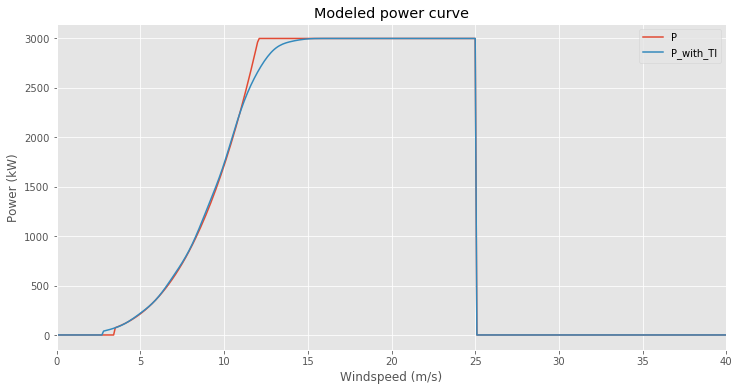

In [5]:
fig, ax = plt.subplots(figsize = (12, 6))
df_bpc.plot(ax = ax)
plt.title('Modeled power curve')
plt.ylabel('Power (kW)')
plt.xlabel('Windspeed (m/s)')